<a href="https://colab.research.google.com/github/eteeislam81-arch/Etee-s-project/blob/main/shallow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf, platform, psutil, os, subprocess, sys

print("Python:", sys.version)
print("TF version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# CPU + RAM quick peek
try:
    import psutil
    vm = psutil.virtual_memory()
    print(f"RAM total: {vm.total/1e9:.2f} GB; available: {vm.available/1e9:.2f} GB")
except:
    pass

# CPU model (Linux)
!grep "model name" /proc/cpuinfo | head -n 1 || true


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TF version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
RAM total: 13.61 GB; available: 11.72 GB
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATA_DIR  = "/content/drive/MyDrive/NIH_Dataset"
IMAGE_DIR = f"{DATA_DIR}/train_images"   # folder with all images
LABELS_CSV = f"{DATA_DIR}/labels.csv"    # <-- change if your file has a different name

import pandas as pd

labels = pd.read_csv(LABELS_CSV)
print("CSV loaded with shape:", labels.shape)
labels.head()



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/NIH_Dataset/labels.csv'

In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive/NIH_Dataset"

print("Files in NIH_Dataset folder:")
print(os.listdir(DATA_DIR)[:20])  # show first 20 entries


Files in NIH_Dataset folder:
['labels_train.csv', 'test_images', 'train_images', 'shallow_model.h5', 'shallow_model.keras', 'my_cnn_model.h5', 'deep_mlp.keras', 'deep_mlp_checkpoint.keras', 'deep_mlp_final.keras', 'deep_mlp_accuracy.png', 'deep_mlp_loss.png', 'deep_mlp_training_curves.png']


In [ ]:
import pandas as pd

LABELS_CSV = "/content/drive/MyDrive/NIH_Dataset/labels_train.csv"
labels = pd.read_csv(LABELS_CSV)

print("CSV shape:", labels.shape)
labels.head()


CSV shape: (4672, 2)


,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2


In [ ]:
import os

IMAGE_DIR = "/content/drive/MyDrive/NIH_Dataset/train_images"

labels['file_path'] = labels['file_name'].apply(lambda x: os.path.join(IMAGE_DIR, x))
labels.head()


,file_name,class_id,file_path
0,img_4358977458434011046.jpg,1,/content/drive/MyDrive/NIH_Dataset/train_image...
1,img_5224016757187192130.jpg,2,/content/drive/MyDrive/NIH_Dataset/train_image...
2,img_3065202206106254707.jpg,2,/content/drive/MyDrive/NIH_Dataset/train_image...
3,img_6304894865561547174.jpg,1,/content/drive/MyDrive/NIH_Dataset/train_image...
4,img_3371338542810939877.jpg,2,/content/drive/MyDrive/NIH_Dataset/train_image...


In [ ]:
missing = [fp for fp in labels['file_path'] if not os.path.exists(fp)]
print("Missing files:", len(missing))
print(missing[:10])  # show first 10 missing, if any


Missing files: 4672
['/content/drive/MyDrive/NIH_Dataset/train_images/img_4358977458434011046.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_5224016757187192130.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_3065202206106254707.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_6304894865561547174.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_3371338542810939877.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_946797649386887230.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_3282952127033205295.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_3090153597350897926.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_4875755942606271156.jpg', '/content/drive/MyDrive/NIH_Dataset/train_images/img_4787814488043878610.jpg']


In [ ]:
import os

print("Train images sample:", os.listdir("/content/drive/MyDrive/NIH_Dataset/train_images")[:10])
print("Test images sample:", os.listdir("/content/drive/MyDrive/NIH_Dataset/test_images")[:10])



Train images sample: ['train_images']
Test images sample: ['test_images']


In [ ]:
import os

IMAGE_DIR = "/content/drive/MyDrive/NIH_Dataset/train_images/train_images"

labels['file_path'] = labels['file_name'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# Check again
missing = [fp for fp in labels['file_path'] if not os.path.exists(fp)]
print("Missing files:", len(missing))
print(missing[:10])


Missing files: 0
[]


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train & validation sets (80/20 split)
train_df, val_df = train_test_split(labels, test_size=0.2, stratify=labels['class_id'], random_state=42)

print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)


Train size: (3737, 3)
Validation size: (935, 3)


In [ ]:
import tensorflow as tf

IMG_SIZE = 128  # you can use 64 or 128 depending on memory

def load_and_preprocess(path, label):
    # Load, decode, resize
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)   # grayscale
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    image = tf.reshape(image, [-1])  # flatten for MLP
    return image, label

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df['file_path'], train_df['class_id']))
train_ds = train_ds.map(load_and_preprocess).shuffle(1000).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_path'], val_df['class_id']))
val_ds = val_ds.map(load_and_preprocess).batch(32)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE*IMG_SIZE,)),   # flattened input
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,553,473 (32.63 MB)

 Trainable params: 8,553,473 (32.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 1746s 12s/step - accuracy: 0.4947 - loss: -317.5446 - val_accuracy: 0.4791 - val_loss: -11059.6211
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 34s 235ms/step - accuracy: 0.5001 - loss: -36869.6367 - val_accuracy: 0.4877 - val_loss: -290592.2500
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.5051 - loss: -560041.6250 - val_accuracy: 0.4802 - val_loss: -2377554.7500
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - accuracy: 0.4891 - loss: -3912919.5000 - val_accuracy: 0.5059 - val_loss: -9779047.0000
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step - accuracy: 0.5104 - loss: -12774460.0000 - val_accuracy: 0.5080 - val_loss: -26021450.0000
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - accuracy: 0.5079 - loss: -31545652.0000 - val_accuracy: 0.4845 - val_loss: -57310532.0000
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.4935 - loss: -65740592.0000 - val_accuracy: 0.4941 - val_loss: -114

In [ ]:
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,660,421 (97.89 MB)

 Trainable params: 8,553,473 (32.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,106,948 (65.26 MB)

In [ ]:
# Save shallow model in new format
model.save("/content/drive/MyDrive/NIH_Dataset/shallow_model.keras")

# Later load it
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/NIH_Dataset/shallow_model.keras")



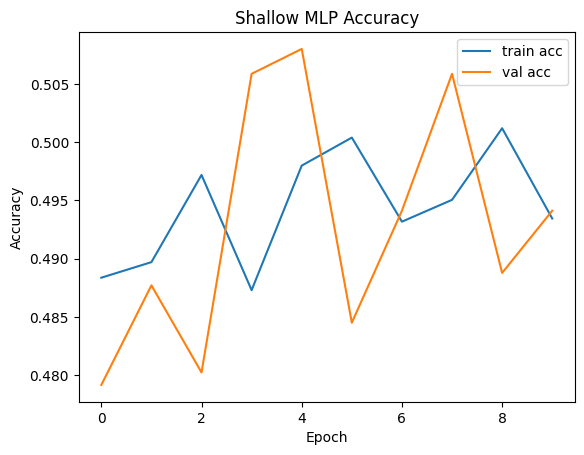

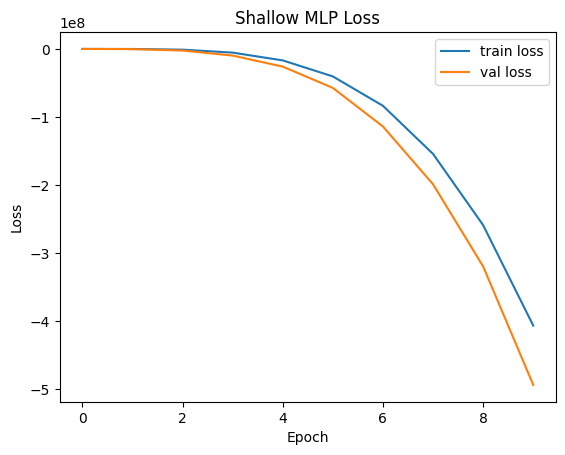

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Shallow MLP Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Shallow MLP Loss')
plt.legend()
plt.show()



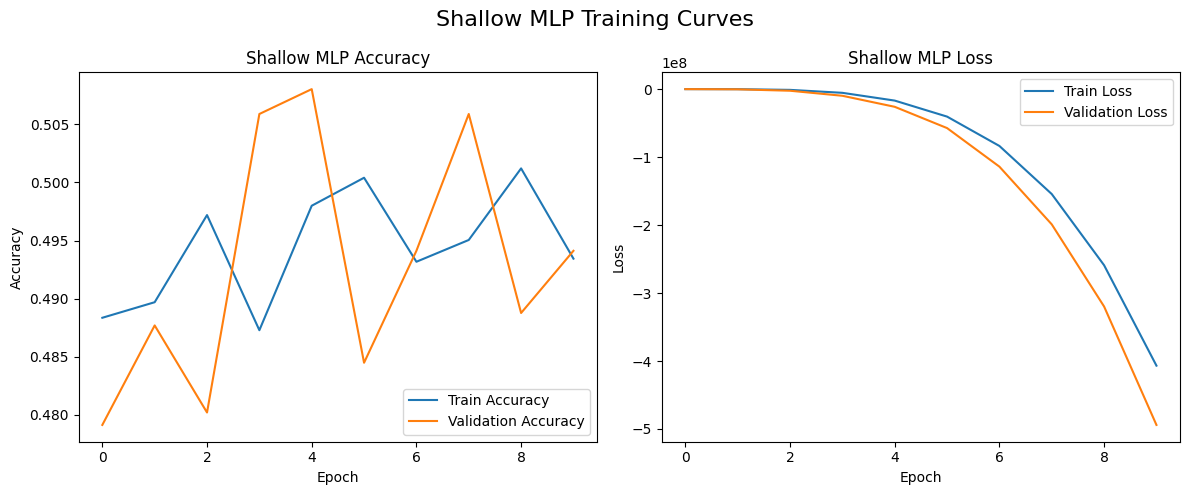

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# ---- Accuracy subplot ----
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Shallow MLP Accuracy')
plt.legend()

# ---- Loss subplot ----
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Shallow MLP Loss')
plt.legend()

plt.suptitle("Shallow MLP Training Curves", fontsize=16)
plt.tight_layout()
plt.show()
